# TITANIC: MACHINE LEARNING FROM DISASTER

Practice Notebook for Kaggle Data Science competitions

In [1]:
# Import al required packages
import os
wd =  os.getcwd()

import pandas as pd
import numpy as np

import seaborn as sns # Makes graphs prettier
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

%timeit
%matplotlib inline
sns.set_style('darkgrid')


In [2]:
# Read the data
X_full = pd.read_csv(wd + "/input/train.csv", index_col="PassengerId")
X_test_full = pd.read_csv(wd + "/input/test.csv", index_col="PassengerId")

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['Survived'], inplace=True)
y = X_full['Survived']
X_full.drop(['Survived'], axis=1, inplace=True)


In [3]:
# Create a family size variable including the passenger themselves
X_full["Fsize"] = X_full.SibSp + X_full.Parch + 1
X_test_full["Fsize"] = X_test_full.SibSp + X_test_full.Parch + 1

In [4]:
# Make a copy of the Name column to obtain the titles
X_full['Title'] = X_full['Name']
X_test_full['Title'] = X_test_full['Name']

# Use regex to get titles from passenger names
regex = '(.*, )|(\..*)'
X_full['Title'].replace(to_replace = regex, value='', inplace=True, regex=True)
X_test_full["Title"].replace(to_replace=regex, value='', inplace=True, regex=True)

rare_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
X_full['Title'].replace(rare_titles, "Rare title", inplace=True)
X_test_full['Title'].replace(rare_titles, "Rare title", inplace=True)

# Also reassign mlle, ms, and mme accordingly
X_full['Title'].replace(["Mlle","Ms", "Mme"], ["Miss", "Miss", "Mrs"], inplace=True)
X_test_full['Title'].replace(["Mlle","Ms", "Mme"], ["Miss", "Miss", "Mrs"], inplace=True)


In [5]:
# Fill Embarqued missing values with the Mode
X_full.Embarked[X_full.Embarked.isna()] = "S"
X_test_full.Embarked[X_test_full.Embarked.isna()] = "S"

In [6]:
# # Break off validation set from training data
# X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
#                                                                 train_size=0.8, test_size=0.2,
#                                                                 random_state=0)

In [8]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() < 10 and 
                    X_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_full[my_cols].copy()
# X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()


In [9]:


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler())])
# numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = GradientBoostingClassifier(learning_rate=0.002,n_estimators=2000,max_depth=5)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# # Preprocessing of training data, fit model 
# clf.fit(X_train, y_train)

# # Preprocessing of validation data, get predictions
# preds = clf.predict(X_valid)

# print('Accuracy:', accuracy_score(y_valid, preds))


In [10]:
# Cross Validation
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(clf, X_train, y,
                              cv=5)

print("Scores:\n", scores)
print("Mean score:\n", scores.mean())

Scores:
 [-0.83798883 -0.82122905 -0.87078652 -0.80898876 -0.85310734]
Mean score:
 -0.8384201005253233


# Test different models

In [11]:
MLA = []
Z = [LinearSVC() , DecisionTreeClassifier() , LogisticRegression() , KNeighborsClassifier() , GaussianNB() ,
    RandomForestClassifier() , GradientBoostingClassifier()]
X = ["LinearSVC" , "DecisionTreeClassifier" , "LogisticRegression" , "KNeighborsClassifier" , "GaussianNB" ,
    "RandomForestClassifier" , "GradientBoostingClassifier"]

for i in range(0,len(Z)):
    model = Z[i]

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
    
    scores = -1 * cross_val_score(clf, X_train, y,
                              cv=5)
    # model.fit( X_train , y_train )
    # pred = model.predict(X_test)
    MLA.append(scores.mean())
MLA   

[-0.821591418075195,
 -0.7811028279795602,
 -0.8160048258964242,
 -0.8160297213938499,
 -0.8081082010804362,
 -0.8215658133043382,
 -0.8350239220196418]

In [12]:
d = { "Accuracy" : MLA , "Algorithm" : X }
dfm = pd.DataFrame(d)
dfm

,Accuracy,Algorithm
0,-0.821591,LinearSVC
1,-0.781103,DecisionTreeClassifier
2,-0.816005,LogisticRegression
3,-0.816030,KNeighborsClassifier
4,-0.808108,GaussianNB
5,-0.821566,RandomForestClassifier
6,-0.835024,GradientBoostingClassifier


# Parameter Tuning

In [13]:
#Logistic Regression 
model = LogisticRegression()
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

parameters = {}
parameters['model__C'] = np.logspace(-3,3,7)
parameters['model__penalty'] = ['l2','l1']

gsLR = GridSearchCV(clf, param_grid = parameters, cv=5)
gsLR.fit(X_train,y)

print("BEST PARAMS: ",gsLR.best_params_)
print("BEST SCORE:", gsLR.best_score_)

BEST PARAMS:  {'model__C': 1.0, 'model__penalty': 'l2'}
BEST SCORE: 0.8159371492704826


In [14]:
#KNN
model = KNeighborsClassifier()
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

parameters = {}
parameters['model__n_neighbors'] = [3,4,5,6,8,9,10]
parameters['model__metric'] = ['euclidean','manhattan','chebyshev','minkowski']

gsKNN = GridSearchCV(clf, param_grid = parameters, cv=5)
gsKNN.fit(X_train,y)

print("BEST PARAMS: ",gsKNN.best_params_)
print("BEST SCORE:",gsKNN.best_score_)

BEST PARAMS:  {'model__metric': 'manhattan', 'model__n_neighbors': 8}
BEST SCORE: 0.8226711560044894


In [15]:
model = RandomForestClassifier()
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

parameters = {}
parameters['model__n_estimators'] = [100, 125, 150, 175, 200, 300]
parameters['model__max_depth'] = [3,4,5,6]

gsRF = GridSearchCV(clf, param_grid = parameters, cv=5, n_jobs=-1)
gsRF.fit(X_train,y)

print("BEST PARAMS: ",gsRF.best_params_)
print("BEST SCORE:",gsRF.best_score_)


BEST PARAMS:  {'model__max_depth': 4, 'model__n_estimators': 300}
BEST SCORE: 0.8338945005611672


In [16]:
model = GradientBoostingClassifier()
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

parameters = {}
parameters['model__learning_rate'] = [0.0018, 0.002, 0.0022]
parameters['model__n_estimators'] = [1800,2000,2200]
parameters['model__max_depth'] = [4,5,6]

gsGBC = GridSearchCV(clf, param_grid = parameters, cv=5, n_jobs=-1)
gsGBC.fit(X_train,y)

print("BEST PARAMS: ", gsGBC.best_params_)
print("BEST SCORE:", gsGBC.best_score_)


BEST PARAMS:  {'model__learning_rate': 0.0018, 'model__max_depth': 5, 'model__n_estimators': 2000}
BEST SCORE: 0.8406285072951739


logreg model AUC = 0.8136084747387594 
random forest model AUC =0.8179704726296616
KNN model AUC = 0.8243217332949861
GBC Boost model AUC = 0.9048509251270253


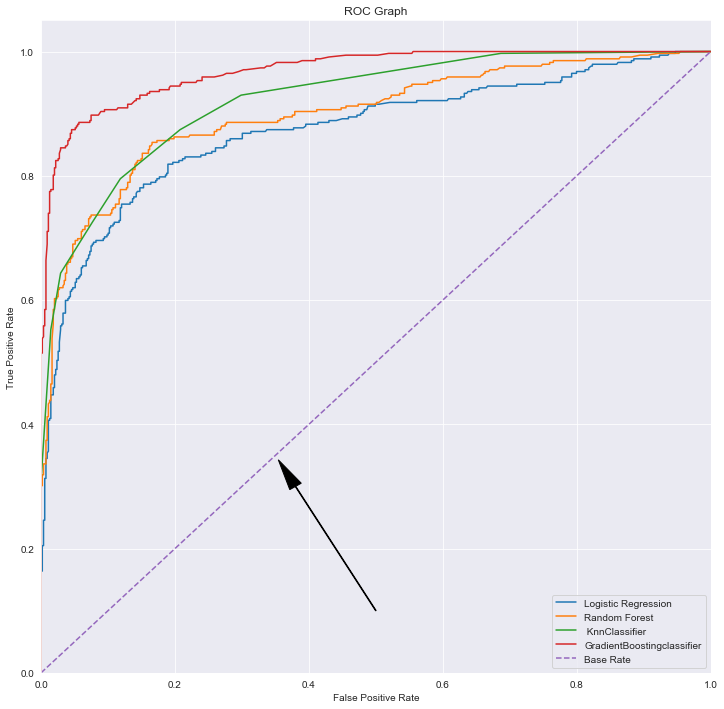

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, gsLR.predict_proba(X_train)[:,1]) # Logistic Regression
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y, gsRF.predict_proba(X_train)[:,1]) # Random Forest
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y, gsKNN.predict_proba(X_train)[:,1]) # K Nearest neighbors
gbc_fpr, gbc_tpr, ada_thresholds = roc_curve(y, gsGBC.predict_proba(X_train)[:,1]) #Gradient Boosting Classifier

plt.figure(figsize=(12,12))
log_roc_auc = roc_auc_score(y, gsLR.predict(X_train)) # Logistic Regression
print ("logreg model AUC = {} " .format(log_roc_auc))
rf_roc_auc = roc_auc_score(y, gsRF.predict(X_train)) # Random Forest
print ("random forest model AUC ={}" .format(rf_roc_auc))
knn_roc_auc = roc_auc_score(y, gsKNN.predict(X_train)) # KNN
print ("KNN model AUC = {}" .format(knn_roc_auc))
gbc_roc_auc = roc_auc_score(y, gsGBC.predict(X_train)) # Gradient Boosting
print ("GBC Boost model AUC = {}" .format(gbc_roc_auc))
# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression')

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest')

# Plot Decision Tree ROC
plt.plot(knn_fpr, knn_tpr, label=' KnnClassifier')

# Plot GradientBooseting Boost ROC
plt.plot(gbc_fpr, gbc_tpr, label='GradientBoostingclassifier')

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate',linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")

plt.arrow(0.5, 0.1, -0.12, 0.2, head_width=0.02, head_length=0.05, fc='k', ec='k')
plt.show()

In [18]:
test_PassengerId = X_test_full.index
Survived=gsGBC.predict(X_test)
submission = pd.concat([pd.DataFrame(test_PassengerId), pd.DataFrame({'Survived':Survived})], axis=1)
submission.to_csv('C:\\Users\\mjant\\submission.csv', index=False) 